# 1. Libraries

In [1]:
# !pip install sklearn
# !pip install fancyimpute
# !pip install missingpy

In [2]:
import sklearn
print(sklearn.__version__)


1.2.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import IterativeImputer as MICE
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import learning_curve

In [5]:
from sklearn.inspection import permutation_importance

# 2. Preparation

In [6]:
df = pd.read_csv('processed/df_numeric.csv')

# Select columns with numerical data
numerical_cols = df.select_dtypes(include=['float64']).columns

imputation_methods = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'mode': SimpleImputer(strategy='most_frequent'),
    'KNN': KNNImputer(n_neighbors=2),
    'MICE': MICE(),
    'Iterative': IterativeImputer(random_state=0),
}

df.head()

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,class
0,48.0,80.0,1.020,1.0,0.0,NaN,1.0,0.0,0.0,121.0,...,44.0,7800.0,5.2,1.0,1.0,0.0,1.0,0.0,0.0,True
1,7.0,50.0,1.020,4.0,0.0,NaN,1.0,0.0,0.0,NaN,...,38.0,6000.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,True
2,62.0,80.0,1.010,2.0,3.0,1.0,1.0,0.0,0.0,423.0,...,31.0,7500.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,True
3,48.0,70.0,1.005,4.0,0.0,1.0,0.0,1.0,0.0,117.0,...,32.0,6700.0,3.9,1.0,0.0,0.0,0.0,1.0,1.0,True
4,51.0,80.0,1.010,2.0,0.0,1.0,1.0,0.0,0.0,106.0,...,35.0,7300.0,4.6,0.0,0.0,0.0,1.0,0.0,0.0,True


In [7]:
categorical = df.select_dtypes(exclude=np.number)
a = df.info(verbose=True)

print(a)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      340 non-null    float64
 1   blood_pressure           337 non-null    float64
 2   specific_gravity         302 non-null    float64
 3   albumin                  303 non-null    float64
 4   sugar                    300 non-null    float64
 5   red_blood_cells          200 non-null    float64
 6   pus_cell                 287 non-null    float64
 7   pus_cell_clumps          345 non-null    float64
 8   bacteria                 345 non-null    float64
 9   blood_glucose_random     306 non-null    float64
 10  blood_urea               331 non-null    float64
 11  serum_creatinine         332 non-null    float64
 12  sodium                   263 non-null    float64
 13  potassium                262 non-null    float64
 14  hemoglobin               2

# 3. Functions

In [8]:

for impute_name, imputer in imputation_methods.items():
    print(f"Imputing with {impute_name} method")
    df_imputed = df.copy()
    df_imputed[numerical_cols] = imputer.fit_transform(df_imputed[numerical_cols])

    # Fill missing values in categorical columns with the most frequent category
    for cat_col in df_imputed.select_dtypes(include=['object']).columns:
        df_imputed[cat_col].fillna(df_imputed[cat_col].mode()[0], inplace=True)

    # Preprocessing
    label_encoders = {}
    for cat_col in df_imputed.select_dtypes(include=['object']).columns:
        label_encoders[cat_col] = LabelEncoder()
        df_imputed[cat_col] = label_encoders[cat_col].fit_transform(df_imputed[cat_col])

    scaler = StandardScaler()
    df_imputed[df_imputed.select_dtypes(include=['float64']).columns] = scaler.fit_transform(df_imputed[df_imputed.select_dtypes(include=['float64']).columns])



Imputing with mean method
Imputing with median method
Imputing with mode method
Imputing with KNN method
Imputing with MICE method
Imputing with Iterative method


In [9]:
def train(model, dataframes):
    models = {}
    metrics = {
        'accuracies': {},
        'precisions': {},
        'recalls': {},
        'f1_scores': {},
    }
    confusion_matrices = {}
    learning_curves = {}
    feature_importances = {}

    for (name, dataframe) in dataframes.items():
        print(f'learning with {name} imputed data')
        y = np.asarray(dataframe['class'])
        X = np.asarray(dataframe.drop(columns=['class']))

        # split the dataset to train and test sets. set the test set size to 20%.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.20, random_state=42)

        # Train Decision Tree Classifer
        model = model.fit(X_train, y_train)

        # Predict the response for test dataset
        y_pred = model.predict(X_test)

        # Get accuracy metrics
        accuracy = model.score(X_test, y_test)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        confusion = confusion_matrix(y_test, y_pred)

        # Save the model and metrics
        models[name] = model
        metrics['accuracies'][name] = accuracy
        metrics['precisions'][name] = precision
        metrics['recalls'][name] = recall
        metrics['f1_scores'][name] = f1
        confusion_matrices[name] = confusion

        # Calculate learning curve
        learning_curve_values = learning_curve(model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
        learning_curves[name] = learning_curve_values

        # Calculate feature importance
        importances = permutation_importance(model, X_test, y_test, n_repeats=10)
        feature_importances[name] = pd.DataFrame(sorted(zip(dataframe.drop(columns=['class']).columns, importances.importances_mean), key=lambda tup: tup[1], reverse=True), columns=['Feature', 'Importance'])

    # Return the models, metrics, confusion matrices, learning curves and feature importances
    return models, metrics, confusion_matrices, learning_curves, feature_importances


In [10]:
def plot_metrics(metrics):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0, 0].bar(metrics['accuracies'].keys(), metrics['accuracies'].values())
    axs[0, 0].set_title('Accuracy')

    axs[0, 1].bar(metrics['precisions'].keys(), metrics['precisions'].values())
    axs[0, 1].set_title('Precision')

    axs[1, 0].bar(metrics['recalls'].keys(), metrics['recalls'].values())
    axs[1, 0].set_title('Recall')

    axs[1, 1].bar(metrics['f1_scores'].keys(), metrics['f1_scores'].values())
    axs[1, 1].set_title('F1 Score')

    plt.tight_layout()
    plt.show()

In [11]:
def plot_confusion_matrices(confusion_matrices):
    for name, cm in confusion_matrices.items():
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True)
        plt.title(f'Confusion matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.show()

In [12]:
from util.functions import plot_feature_importances

In [13]:
def plot_learning_curves(learning_curves):
    import matplotlib.pyplot as plt
    # plot all learning curves as subplots
    num_curves = len(learning_curves.items())

    # Set up the figure and subplots
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

    # Iterate over each confusion matrix and plot it as a heatmap in a subplot
    for i, (name, curve) in enumerate(learning_curves.items()):
        # curve is this: learning_curve(model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
        train_sizes = curve[0]
        train_scores = curve[1]
        test_scores = curve[2]

        # plot the train and test scores
        axs.flat[i].grid()
        axs.flat[i].plot(train_sizes, train_scores.mean(
            axis=1), 'o-', color="r", label="Training score")
        axs.flat[i].plot(train_sizes, test_scores.mean(
            axis=1), 'o-', color="g", label="Cross-validation score")
        axs.flat[i].legend(loc="best")
        axs.flat[i].set_title(f'Learning Curve {name}')
        axs.flat[i].set_xlabel('Training examples')
        axs.flat[i].set_ylabel('Score')

    # Add a colorbar and adjust the layout
    fig.tight_layout()

    # Show the plot
    plt.show()

# feature importances is a dict of dataframes


# 4. Train

In [18]:
all_train_losses = {}
all_val_losses = {}
all_train_accuracies = {}
all_val_accuracies = {}
epochsx = 5
# create a dictionary to store all the metrics
all_val_metrics = {
    'confusion_matrix': {},
    'classification_report': {}
}


for impute_name, imputer in imputation_methods.items():
    print(f"Imputing with {impute_name} method")
    df_imputed = df.copy()
    df_imputed[numerical_cols] = imputer.fit_transform(df_imputed[numerical_cols])

    # Fill missing values in categorical columns with the most frequent category
    for cat_col in df_imputed.select_dtypes(include=['object']).columns:
        df_imputed[cat_col].fillna(df_imputed[cat_col].mode()[0], inplace=True)


    # Splitting the dataset
    train_df, temp_df = train_test_split(df_imputed, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    class CKDDataset(Dataset):
        def __init__(self, data):
            self.data = torch.tensor(data.drop(columns='class').values, dtype=torch.float32)
            self.targets = torch.tensor(data['class'].values, dtype=torch.long)

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx], self.targets[idx]

    train_dataset = CKDDataset(train_df)
    train_loader = DataLoader(train_dataset, batch_size=16)

    val_dataset = CKDDataset(val_df)
    val_loader = DataLoader(val_dataset, batch_size=16)

    test_dataset = CKDDataset(test_df)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Define the network architecture
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()

            self.fc1 = nn.Linear(24, 24)
            self.fc2 = nn.Linear(24, 2)
            self.dropout = nn.Dropout(0.2) # 20% dropout rate

        def forward(self, x):
            x = nn.functional.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    # Initialize the network and define the loss function and optimizer
    model = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochsx):
        model.train()
        train_loss = 0.0
        correct = total = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = correct / total
        train_accuracies.append(train_acc)
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = total_val = 0
        val_preds = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_preds.extend(predicted.tolist())
                total_val += targets.size(0)
                correct_val += predicted.eq(targets).sum().item()


        val_acc = correct_val / total_val
        val_loss /= len(val_loader)

        # Calculate confusion matrix and classification report
        cm = confusion_matrix(val_df['class'], np.array(val_preds))
        cr = classification_report(val_df['class'], np.array(val_preds), output_dict=True)

        all_val_metrics['confusion_matrix'][impute_name] = cm
        all_val_metrics['classification_report'][impute_name] = cr

        print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}')

        all_train_losses[impute_name] = train_losses
        all_val_losses[impute_name] = val_losses
        all_train_accuracies[impute_name] = train_accuracies
        all_val_accuracies[impute_name] = val_accuracies



Imputing with mean method
Epoch: 1, Train Loss: 243.486, Val Loss: 28.875, Train Acc: 0.361, Val Acc: 0.308
Epoch: 2, Train Loss: 72.480, Val Loss: 60.576, Train Acc: 0.602, Val Acc: 0.692
Epoch: 3, Train Loss: 81.965, Val Loss: 40.224, Train Acc: 0.648, Val Acc: 0.692
Epoch: 4, Train Loss: 45.346, Val Loss: 16.499, Train Acc: 0.590, Val Acc: 0.692
Epoch: 5, Train Loss: 46.629, Val Loss: 26.530, Train Acc: 0.615, Val Acc: 0.692
Imputing with median method
Epoch: 1, Train Loss: 96.160, Val Loss: 43.362, Train Acc: 0.713, Val Acc: 0.692
Epoch: 2, Train Loss: 41.232, Val Loss: 1.383, Train Acc: 0.574, Val Acc: 0.692
Epoch: 3, Train Loss: 36.378, Val Loss: 20.278, Train Acc: 0.570, Val Acc: 0.692
Epoch: 4, Train Loss: 28.096, Val Loss: 7.755, Train Acc: 0.594, Val Acc: 0.692
Epoch: 5, Train Loss: 22.753, Val Loss: 7.658, Train Acc: 0.611, Val Acc: 0.692
Imputing with mode method
Epoch: 1, Train Loss: 107.843, Val Loss: 71.880, Train Acc: 0.693, Val Acc: 0.692
Epoch: 2, Train Loss: 67.746, 

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

Epoch: 1, Train Loss: 208.830, Val Loss: 136.216, Train Acc: 0.717, Val Acc: 0.692
Epoch: 2, Train Loss: 87.350, Val Loss: 14.281, Train Acc: 0.664, Val Acc: 0.673
Epoch: 3, Train Loss: 91.122, Val Loss: 57.640, Train Acc: 0.480, Val Acc: 0.692
Epoch: 4, Train Loss: 67.430, Val Loss: 40.511, Train Acc: 0.619, Val Acc: 0.692
Epoch: 5, Train Loss: 67.978, Val Loss: 27.759, Train Acc: 0.549, Val Acc: 0.692
Imputing with MICE method
Epoch: 1, Train Loss: 151.191, Val Loss: 92.083, Train Acc: 0.721, Val Acc: 0.692
Epoch: 2, Train Loss: 76.923, Val Loss: 12.682, Train Acc: 0.615, Val Acc: 0.692
Epoch: 3, Train Loss: 53.234, Val Loss: 20.836, Train Acc: 0.549, Val Acc: 0.692
Epoch: 4, Train Loss: 42.880, Val Loss: 15.883, Train Acc: 0.602, Val Acc: 0.692
Epoch: 5, Train Loss: 36.441, Val Loss: 22.972, Train Acc: 0.607, Val Acc: 0.692
Imputing with Iterative method
Epoch: 1, Train Loss: 109.684, Val Loss: 86.057, Train Acc: 0.586, Val Acc: 0.692
Epoch: 2, Train Loss: 85.803, Val Loss: 51.090, 

/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisastue/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisas

# 3. Model Creation

# 5. Evaluation

# 6. Visualizing the performance

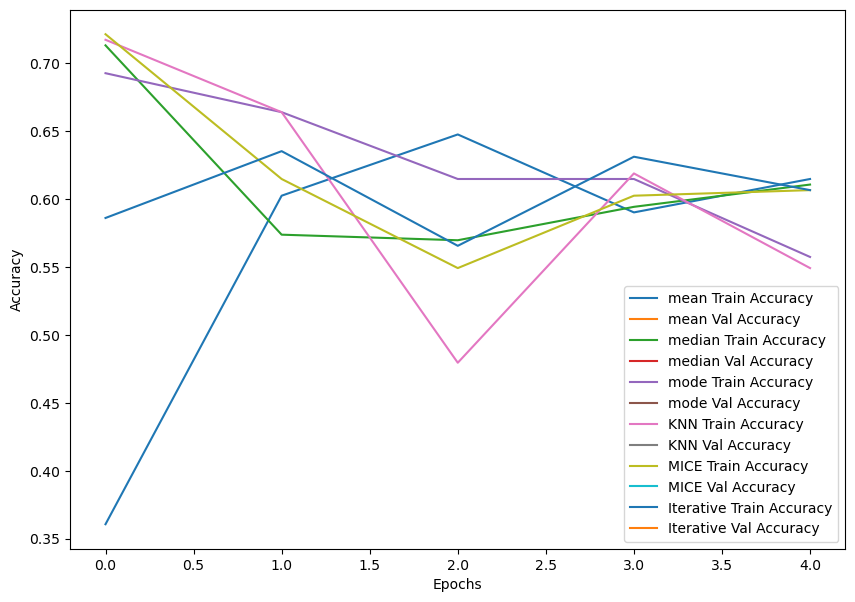

In [19]:
# Plotting train and validation accuracy
plt.figure(figsize=(10,7))
for impute_name in imputation_methods.keys():
    try:
        plt.plot(all_train_accuracies[impute_name], label=f'{impute_name} Train Accuracy')
        plt.plot(all_val_accuracies[impute_name], label=f'{impute_name} Val Accuracy')
    except KeyError:
        print(f"No data for {impute_name} in train/val accuracies")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

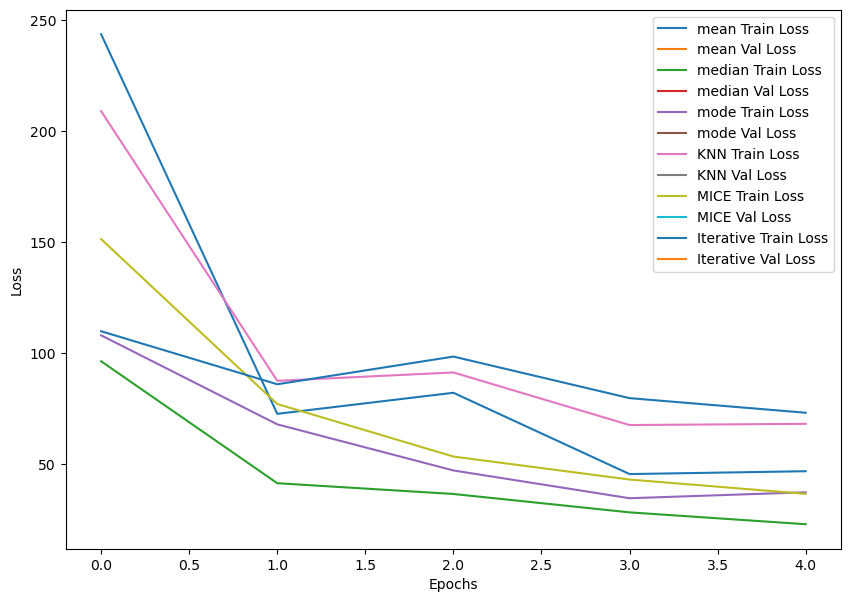

In [20]:
# Plotting train and validation loss
plt.figure(figsize=(10,7))
for impute_name in imputation_methods.keys():
    try:
        plt.plot(all_train_losses[impute_name], label=f'{impute_name} Train Loss')
        plt.plot(all_val_losses[impute_name], label=f'{impute_name} Val Loss')
    except KeyError:
        print(f"No data for {impute_name} in train/val losses")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 7. evaluate on the test set

In [ ]:
# Print metrics
for impute_name in imputation_methods.keys():
    try:
        print(f'For {impute_name} imputation:')
        print('Confusion Matrix:')
        print(all_val_metrics['confusion_matrix'][impute_name])
        print('Classification Report:')
        print(all_val_metrics['classification_report'][impute_name])
        print()
    except KeyError:
        print(f"No data for {impute_name} in validation metrics")

For mean imputation:
Confusion Matrix:
[[16  0]
 [ 3 33]]
Classification Report:
{'False': {'precision': 0.8421052631578947, 'recall': 1.0, 'f1-score': 0.9142857142857143, 'support': 16}, 'True': {'precision': 1.0, 'recall': 0.9166666666666666, 'f1-score': 0.9565217391304348, 'support': 36}, 'accuracy': 0.9423076923076923, 'macro avg': {'precision': 0.9210526315789473, 'recall': 0.9583333333333333, 'f1-score': 0.9354037267080746, 'support': 52}, 'weighted avg': {'precision': 0.951417004048583, 'recall': 0.9423076923076923, 'f1-score': 0.9435260391782131, 'support': 52}}

For median imputation:
Confusion Matrix:
[[16  0]
 [ 1 35]]
Classification Report:
{'False': {'precision': 0.9411764705882353, 'recall': 1.0, 'f1-score': 0.9696969696969697, 'support': 16}, 'True': {'precision': 1.0, 'recall': 0.9722222222222222, 'f1-score': 0.9859154929577464, 'support': 36}, 'accuracy': 0.9807692307692307, 'macro avg': {'precision': 0.9705882352941176, 'recall': 0.9861111111111112, 'f1-score': 0.9778